In [3]:
import torch
import numpy as np

import matplotlib.pyplot as plt

from torch import nn
from torchvision import datasets, transforms

# Prepare data

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])

# Download and load the training data
trainset = datasets.MNIST("MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Define network

In [11]:
# Define a feed-forward network
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10) # logits, instead of output of the softmax
)

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get data
images, labels = next(iter(trainloader))

# Flatten images
images = images.view(images.shape[0], -1)

In [12]:
# forward pass to get the logits
logits = model(images)

# pass the logits to criterion to get the loss
loss = criterion(logits, labels)

print(loss)

tensor(2.2984, grad_fn=<NllLossBackward>)


# Use `nn.LogSoftmax` and `nn.NLLLoss`
It is more convinient to build model with log-softmax output instead of output from Linear and use the negative log likelihood loss.

Then, you can get the actual probabilities by taking torch.exp(output) instead of taking softmax function

In [21]:
# Define a feed-forward network
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1) # dim=1 to calc softmax across columns instead of rows
)

# Define the loss
criterion = nn.NLLLoss()

# Get data
images, labels = next(iter(trainloader))

# Flatten images
images = images.view(images.shape[0], -1)

In [23]:
# forward pass to get the logits
log_probs = model(images)

# pass the logits to criterion to get the loss
loss = criterion(log_probs, labels)

print(loss)

tensor(2.3229, grad_fn=<NllLossBackward>)


# Use Autograd to perform backpropagation

In [38]:
x = torch.randn(2, 2, requires_grad=True)
print(x)

tensor([[ 1.2292, -0.0670],
        [ 0.3727,  0.7215]], requires_grad=True)


In [39]:
y = x ** 2
print(y)
print(y.grad_fn)

tensor([[1.5109, 0.0045],
        [0.1389, 0.5205]], grad_fn=<PowBackward0>)


In [40]:
z = y.mean()
print(z)

tensor(0.5437, grad_fn=<MeanBackward1>)


In [41]:
print(x.grad)

None


calculate the gradients

In [42]:
z.backward()

In [48]:
print("grad: ", x.grad)
print("x:", x)
print("x/2: ", x / 2) # equal to gradients mathamatically = x / 2

grad:  tensor([[ 0.6146, -0.0335],
        [ 0.1864,  0.3607]])
x: tensor([[ 1.2292, -0.0670],
        [ 0.3727,  0.7215]], requires_grad=True)
x/2:  tensor([[ 0.6146, -0.0335],
        [ 0.1864,  0.3607]], grad_fn=<DivBackward0>)


## Try to perform backward pass and get the gradients

In [54]:
print("Before backward pass: \n", model[0].weight.grad)

loss.backward()

print("After backward pass: \n", model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [-0.0026, -0.0026, -0.0026,  ..., -0.0026, -0.0026, -0.0026],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        ...,
        [-0.0035, -0.0035, -0.0035,  ..., -0.0035, -0.0035, -0.0035],
        [-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019],
        [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001]])


# Training the network

Use the optimizer from PyTorch `optim` package to update weights with the gradients. For example, stochastic gradient descent is `optim.SGD`

In [56]:
from torch import optim

# Optimizers require the parameters to optimize and the learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Try the optimizer to update weights

The general process with Pytorch:
- Make a forward pass
- Calculate loss
- Perform backward pass with loss.backward()
- Take a step with optimizer to update the weights

In [63]:
print("Initial weights: \n", model[0].weight)

images, labels = next(iter(trainloader))
images = images.view(64, 784)

# !Important: Clear the gradients. otherwise, the gradients will be accumulated
optimizer.zero_grad()

# Forward pass
output = model.forward(images)
loss = criterion(output, labels)

# Backward pass
loss.backward()

print("Gradient: \n", model[0].weight.grad)

# Take a update step with the optimizer
optimizer.step()

print("Updated weights: \n", model[0].weight)

Initial weights: 
 Parameter containing:
tensor([[ 0.0081,  0.0258,  0.0300,  ...,  0.0350, -0.0177, -0.0321],
        [-0.0066,  0.0236, -0.0282,  ...,  0.0331,  0.0227,  0.0195],
        [-0.0145, -0.0124,  0.0335,  ...,  0.0044, -0.0012,  0.0035],
        ...,
        [-0.0130,  0.0051, -0.0198,  ..., -0.0084,  0.0017,  0.0072],
        [-0.0137,  0.0196,  0.0293,  ...,  0.0093,  0.0272, -0.0152],
        [-0.0330,  0.0202,  0.0066,  ...,  0.0088, -0.0242,  0.0046]],
       requires_grad=True)
Gradient: 
 tensor([[-0.0009, -0.0009, -0.0009,  ..., -0.0009, -0.0009, -0.0009],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [-0.0026, -0.0026, -0.0026,  ..., -0.0026, -0.0026, -0.0026],
        ...,
        [-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [ 0.0047,  0.0047,  0.0047,  ...,  0.0047,  0.0047,  0.0047],
        [-0.0004, -0.0004, -0.0004,  ..., -0.0004, -0.0004, -0.0004]])
Updated weights: 
 Parameter containing:
tensor([[ 0

## Actually training

In [68]:
epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten
        images = images.view(images.shape[0], -1)
        
        # !Important: Clear the gradients. otherwise, the gradients will be accumulated
        optimizer.zero_grad()

        # Forward pass
        output = model.forward(images)
        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Take a update step with the optimizer
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.23869899142462053
Training loss: 0.219593421109259
Training loss: 0.20316559299906053
Training loss: 0.1880630064906596
Training loss: 0.1747898718298498


# Get the predictions

In [88]:
images, labels = next(iter(trainloader))

img = images[0].view(1, -1)

# turn off gradients to speed up
with torch.no_grad():
    probs = model.forward(img)

output = torch.exp(probs)

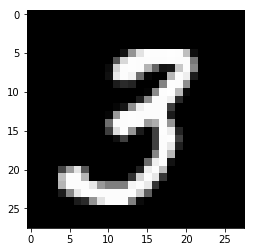

In [95]:
plt.imshow(img.view(1, 28, 28).squeeze(), cmap='gray')

In [90]:
print(output.numpy())
print("predict:", np.argmax(output))

[[1.4732439e-07 1.2705384e-06 6.6373350e-06 9.9960142e-01 2.9570666e-08
  2.3409531e-04 4.2051900e-11 6.8191332e-07 1.4067911e-04 1.5030907e-05]]
predict: tensor(3)
